About: Loan Defaulters Classifications with ensemble method
Dataset1: Dataset link - https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Experimental Aim: To compare the performance of loan defaulters classifications with ensemble and dense aritificial neural network method

Results: Performance accuracy

Processses:
- data analysis
- outlier detection and removal
- one-hot-encoding of category variables
- multi-model learning and performance comparison using pipelines
- model improvement with optimizations and hyperparameters tuning
- Inferencing

In [332]:
# set up

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import tree

from sklearn import datasets, linear_model
#import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

## data upload and pre-processing
- upload using pandas
- preprocessing and engineering using using one-hot encoding

In [279]:
# upload data dataframe 
df = pd.read_csv('default_of_credit_card_clients.csv', skiprows=1)
data = df.dropna()      # removing rows with null values if any 
data = df.rename(columns= {'default payment next month': 'default_payment_next_month'})
data.head(2)    # print sample frame by rows
#data.columns
#clear_output(wait=True)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [284]:
# identify and separate category/ continous variables

num_var = data.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis = 1)

cat_var = data.drop(['ID', 'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month'], axis =1)

cat_var.head(2)
cat_var.columns

Index(['SEX', 'EDUCATION', 'MARRIAGE'], dtype='object')

In [301]:
# perform one-hot encoding for category variables

# new generated category variables and data
df = pd.concat([cat_var.drop('SEX', axis=1), pd.get_dummies(cat_var['SEX'],prefix='sex')], axis=1)
df1 = pd.concat([df.drop('EDUCATION', axis=1), pd.get_dummies(df['EDUCATION'],prefix='edu')], axis=1)
df2 = pd.concat([df1.drop('MARRIAGE', axis=1), pd.get_dummies(df['MARRIAGE'],prefix='married')], axis=1)

# concatante category variable with numeric variables to have data1

data1  = pd.concat([df2,num_var], axis = 1, sort = False)
data1.head(2)
data1.shape

(30000, 35)

In [308]:
# separate input and inference datasets

input_sample = data1[data1['ID'] <=29950]          # training, test, and validation data
inference_sample = data1[data1['ID']>29950]        # inference sample
input_sample.head(2)
len(inference_sample)


50

## data exploratory analysis
1. outlier removal
- univariate approach
- multivariate approach 

AxesSubplot(0.125,0.125;0.775x0.755)


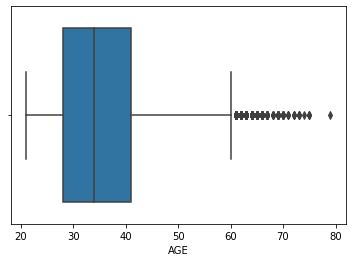

In [309]:
# univariate plot appraoch to analysis

import seaborn as sns
dataplt =sns.boxplot(x=input_sample['AGE'])
print(dataplt)

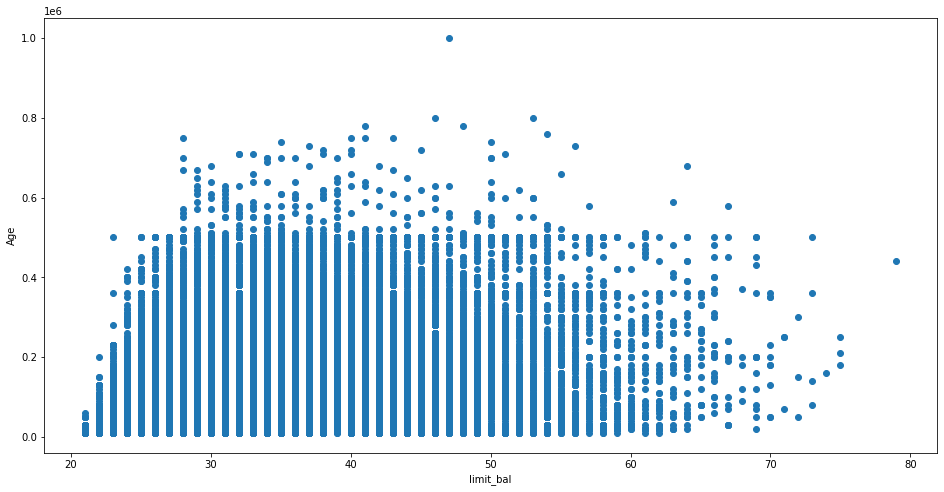

In [310]:
# multivariate plot approach of analysis

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(input_sample['AGE'], input_sample['LIMIT_BAL'])
ax.set_xlabel('limit_bal')
ax.set_ylabel('Age')
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)
(30000, 25)
(29678, 35)


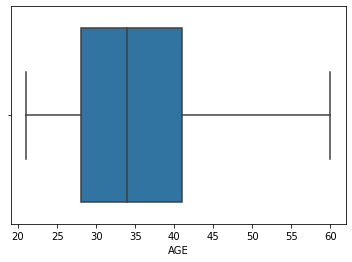

In [315]:
# outlier removal, method 1: Univariate approach
# removal based on age variable. the problem is in the choice of variable of interest for the analysis and removal

data2 = input_sample[input_sample.AGE <=60]
data2.shape[0]

#visualisations
data2plt = sns.boxplot(x=data2['AGE'])
print(data2plt)

print(data.shape)     # original data
print(data2.shape)    # cleaned data


In [330]:
#train input(X) /target(y) features separation

target_feat = 'default_payment_next_month'
X = input_sample.drop(target_feat, axis = 1)
y = input_sample[target_feat]
X.shape

(29950, 34)

(array([    6,     6,     6, ..., 29939, 29943, 29944], dtype=int64), array([14, 22, 23, ..., 32, 14, 16], dtype=int64))
(23759, 34)
(29950, 34)
(23759,)
AxesSubplot(0.125,0.125;0.775x0.755)


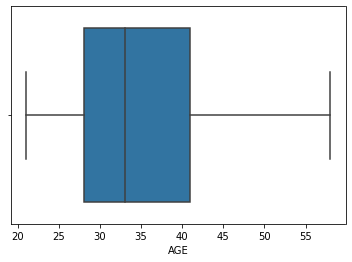

In [335]:
# outlier removal, method 2: multivariate approach
# removal using zscore, best approach since it the distribution is checked for all variables

# check the statistics
z = np.abs(stats.zscore(X))
#print(z)

# detect outlier using at the threshold(between -2.5 and +2.5 interval)- 99% normal distribution confidence interval.
thresh = 2.5
print(np.where(z > thresh))

# apply outlier removal to train dataset

data_train = X[(z < 2.5).all(axis =1)]
print(data_train.shape)      # clean data for training
print(X.shape)               # unclean data

# apply outlier removal to target dataset
data_target = y[(z < 2.5).all(axis =1)]
print(data_target.shape)

# visualisation by age
#visualisations
data_train_plt = sns.boxplot(x=data_train['AGE'])
print(data_train_plt)



In [337]:
# perform train and validation test data split

X_train, X_test, y_train, y_test = train_test_split(data_train, data_target, test_size=0.33, random_state=42)

## model pipelines creations and learning

In [131]:
# Construct learning pipelines for classification model

#support vector machine
pipe_svm = Pipeline([('p1', StandardScaler()),
                      ('pca', PCA(n_components =20)),
                      ('svm', svm.SVC(random_state = 5))])


# logistic regression
pipe_lr = Pipeline([('p2', StandardScaler()),
                      ('pca', PCA(n_components =20)),
                      ('lr', LogisticRegression(random_state=20))])

# adaboost
pipe_ab = Pipeline([('p3', StandardScaler()),
                      ('pca', PCA(n_components =20)),
                      ('ab', AdaBoostClassifier(n_estimators = 100, random_state = 20))])

# decision tree
pipe_dt = Pipeline([('p4', StandardScaler()),
                      ('pca', PCA(n_components =20)),
                      ('dt', tree.DecisionTreeClassifier(random_state=20))])


# KNN
pipe_knn = Pipeline([('p5', StandardScaler()),
                      ('pca', PCA(n_components =20)),
                      ('knn', KNeighborsClassifier(n_neighbors=6, metric='euclidean'))])

# Random Forest (rf) network
num_trees =100
max_features = 5
pipe_rf = Pipeline([('p6', StandardScaler()),
                      ('pca', PCA(n_components =20)),
                      ('rf', RandomForestClassifier(n_estimators=num_trees,
                                                    max_features=max_features))])



In [338]:
# create a list of pipeline and fit training data on it

classifier_pipe = [pipe_svm, pipe_lr, pipe_ab, pipe_dt, pipe_knn, pipe_rf]

# fit the training data on the classifier pipe

for pipe in classifier_pipe:
    pipe.fit(X_train, y_train)
    

In [340]:
# Performance of existing pipelines on test cases

#create dictionary of pipeline classifiers
pipe_dic = {0: 'svm', 1: 'lr',
2:'adaboost', 3:'dt', 4: 'knn', 5: 'rf'}

# test the performance on test set
for indx, val in enumerate(classifier_pipe):
    print ('%s accuracy on test data: %.3f' % (pipe_dic[indx], val.score(X_test,y_test)))


svm accuracy on test data: 0.817
lr accuracy on test data: 0.806
adaboost accuracy on test data: 0.804
dt accuracy on test data: 0.717
knn accuracy on test data: 0.799
rf accuracy on test data: 0.811


In [342]:
# Best classifier selection

best_accuracy = 0
best_classifier = 0
best_pipeline = ''
for indx, val in enumerate(classifier_pipe):
    if val.score(X_test, y_test) > best_accuracy:
        best_accuracy = val.score(X_test, y_test)
        best_pipeline = val
        best_classifier = indx
        print('%s Classifier has the best accuracy of %.2f' %
              (pipe_dic[best_classifier],best_accuracy))

svm Classifier has the best accuracy of 0.82


## model improvement using Hyperparameter Optimizations

In [344]:
# finding the best model parameters

model_params = {
    'pipe_svm': {
        'model': svm.SVC(gamma ='auto'),
        'params': {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }
    },
    'pipe_lr': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1, 2, 5]
        }
    },
    
}

In [ ]:
# optimiztion - model parameters selection
scores = []

for model_name,xp in model_params.items():
    clf = GridSearchCV(xp['model'], xp['params'], cv=3, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    

In [172]:
# print best parameters
df = pd.DataFrame(scores)
print(df)

      model  best_score                 best_params
0  pipe_svm    0.824186  {'C': 20, 'kernel': 'rbf'}
1   pipe_lr    0.781897                    {'C': 5}


## training and model inferencing using best selected model params

In [179]:
# Build and fit Logistic Regression model

logistic_mdl = LogisticRegression()
logistic_mdl.fit(X_train, y_train)

LogisticRegression()

In [178]:
# Inference with the best validation acruacy

y_predict_reg = logistic_mdl.predict(x_test)
print(accuracy_score(y_test,y_predict_reg))

# matrix visualisation of loan defaulters ( default payment: 1 = Yes , 0 = No)
pd.crosstab(y_test,y_predict_reg)


0.7879714576962283


col_0,0,1
default_payment_next_month,,
0,792,129
1,287,754
